In [1]:
import warnings
warnings.filterwarnings('ignore')

from contradictions import CONTRACTION_MAP

import re
import string
import collections
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Using TensorFlow backend.


## PREPROCESSING

In [2]:
AirlineTweets = pd.read_csv("Tweets.csv")[['text', 'airline_sentiment']]

In [3]:
# Lower Case
AirlineTweets["text"] = AirlineTweets["text"].str.lower()
AirlineTweets.head()

,text,airline_sentiment
0,@virginamerica what @dhepburn said.,neutral
1,@virginamerica plus you've added commercials t...,positive
2,@virginamerica i didn't today... must mean i n...,neutral
3,@virginamerica it's really aggressive to blast...,negative
4,@virginamerica and it's a really big bad thing...,negative


In [4]:
def remove_mentions(tweet):
    return re.sub("@[A-Za-z0-9]+", "", tweet)

AirlineTweets.text = AirlineTweets.text.apply(remove_mentions)
AirlineTweets.head()

,text,airline_sentiment
0,what said.,neutral
1,plus you've added commercials to the experien...,positive
2,i didn't today... must mean i need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative


In [5]:
# Remove Punctuation
AirlineTweets["text"] = AirlineTweets["text"].str.replace('[^\w\s]', '')
AirlineTweets.head()

,text,airline_sentiment
0,what said,neutral
1,plus youve added commercials to the experienc...,positive
2,i didnt today must mean i need to take anothe...,neutral
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative


In [6]:
def remove_stopwords(tweet):
    stopword_list = stopwords.words('english')
    splitted_tweet = tweet.split()
    clean_tweet = [word for word in splitted_tweet if word not in stopword_list]
    return " ".join(clean_tweet) 

AirlineTweets.text = AirlineTweets.text.apply(remove_stopwords)
AirlineTweets.head()

,text,airline_sentiment
0,said,neutral
1,plus youve added commercials experience tacky,positive
2,didnt today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative


In [7]:
def remove_contradictions(tweet):
    splitted_tweet = tweet.split() 
    clean_tweet = [CONTRACTION_MAP[word] if word in CONTRACTION_MAP else word for word in splitted_tweet]
    return " ".join(clean_tweet)

AirlineTweets.text = AirlineTweets.text.apply(remove_contradictions)
AirlineTweets.head()

,text,airline_sentiment
0,said,neutral
1,plus youve added commercials experience tacky,positive
2,didnt today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative


In [8]:
lemmatizer =  WordNetLemmatizer()

def lemmatize(tweet):
    splitted_tweet = tweet.split()
    lemmatized_tweet = [lemmatizer.lemmatize(word, pos="v") for word in splitted_tweet]
    return " ".join(lemmatized_tweet)

AirlineTweets.text = AirlineTweets.text.apply(lemmatize)
AirlineTweets.head()

,text,airline_sentiment
0,say,neutral
1,plus youve add commercials experience tacky,positive
2,didnt today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative


In [9]:
tokenizer = Tokenizer(num_words = 10000,
                      filters=string.punctuation,
                      lower=True,
                      split=" ")

tokenizer.fit_on_texts(AirlineTweets.text)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(AirlineTweets.text, AirlineTweets.airline_sentiment, test_size=0.1, random_state=37)

In [11]:
X_train_encoded = tokenizer.texts_to_matrix(X_train)
X_test_encoded = tokenizer.texts_to_matrix(X_test)

print('"{}" is converted into {}'.format(X_train[200], X_train_encoded[200]))
print('For this example we have {} features with a value of 1.'.format(X_train_encoded[200].sum()))

"website im try check" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 14.0 features with a value of 1.


In [12]:
labelEncoder = LabelEncoder()
y_train_labeled = labelEncoder.fit_transform(y_train)
y_test_labeled = labelEncoder.transform(y_test)
y_train_encoded = to_categorical(y_train_labeled, num_classes=3)
y_test_encoded = to_categorical(y_test_labeled, num_classes=3)

print('"{}" is converted into {}'.format(y_train[0], y_train_labeled[0]))
print('"{}" is converted into {}'.format(y_train[105], y_train_labeled[105]))
print('"{}" is converted into {}'.format(y_train[200], y_train_labeled[200]))
print('"{}" is converted into {}'.format(y_train_labeled[0], y_train_encoded[0]))
print('"{}" is converted into {}'.format(y_train_labeled[105], y_train_encoded[105]))
print('"{}" is converted into {}'.format(y_train_labeled[200], y_train_encoded[200]))

"neutral" is converted into 0
"positive" is converted into 1
"negative" is converted into 2
"0" is converted into [1. 0. 0.]
"1" is converted into [0. 1. 0.]
"2" is converted into [0. 0. 1.]


## DEEP LEARNING

In [13]:
warnings.filterwarnings('ignore')

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(64, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10000))
model.add(Dropout(0.5))

model.add(Dense(64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(3, kernel_initializer = 'uniform', activation = 'softmax'))

# summary
model.summary()

W0602 13:37:05.706660 140649477875456 deprecation_wrapper.py:119] From /home/abdullahdeliogullari/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0602 13:37:05.732736 140649477875456 deprecation_wrapper.py:119] From /home/abdullahdeliogullari/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0602 13:37:05.737718 140649477875456 deprecation_wrapper.py:119] From /home/abdullahdeliogullari/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0602 13:37:05.768285 140649477875456 deprecation_wrapper.py:119] From /home/abdullahdeliogullari/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [14]:
warnings.filterwarnings('ignore')
# Early Stopping
earlyStoppingCallback = [EarlyStopping(monitor='val_loss', patience=20)]
# Compiling the NN
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# Train the NN
model.fit(X_train_encoded,
          y_train_encoded, 
          batch_size = 512, 
          epochs = 60, 
          validation_data=(X_test_encoded,y_test_encoded),
          verbose=0)

W0602 13:37:05.910021 140649477875456 deprecation_wrapper.py:119] From /home/abdullahdeliogullari/.local/lib/python3.5/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0602 13:37:05.941757 140649477875456 deprecation_wrapper.py:119] From /home/abdullahdeliogullari/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0602 13:37:06.093370 140649477875456 deprecation.py:323] From /home/abdullahdeliogullari/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


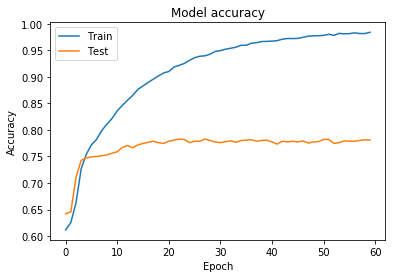

In [15]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
dl_confusion_matrix = confusion_matrix(y_test_encoded.argmax(axis=1), model.predict(X_test_encoded).argmax(axis=1))
print(dl_confusion_matrix)
print ("Neural Train Accuracy:", accuracy_score(y_train_encoded, model.predict(X_train_encoded).round(), normalize=True))
print ("Neural Test Accuracy:", accuracy_score(y_test_encoded, model.predict(X_test_encoded).round(), normalize=True))

[[870  55  15]
 [124 153  15]
 [ 76  36 120]]
Neural Train Accuracy: 0.99013357619915
Neural Test Accuracy: 0.7800546448087432


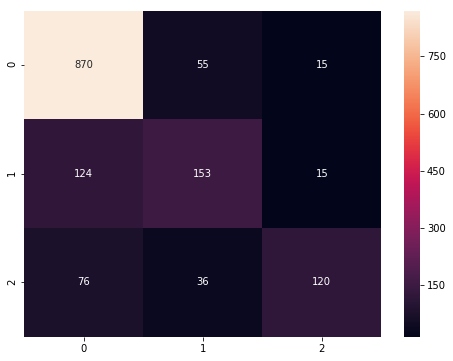

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
sbn.heatmap(dl_confusion_matrix, annot=True, annot_kws={"size": 10}, fmt='g', ax=ax)

In [18]:
sentiments = {0: 'negative', 1: 'neutral', 2: 'positive'}

example_sentence = ["I love this airline. Services are realy good and people are so nice"]
example_encoded = tokenizer.texts_to_matrix(example_sentence)
predicted_scores = model.predict(example_encoded).tolist()
sentiments[np.argmax(predicted_scores)]

'positive'

In [19]:
example_sentence = ["I hate this airline. Services are not good and people are so bad"]
example_encoded = tokenizer.texts_to_matrix(example_sentence)
predicted_scores = model.predict(example_encoded).tolist()
sentiments[np.argmax(predicted_scores)]

'negative'

In [20]:
example_sentence = ["I do not know what to say. Services are not good but also cheap"]
example_encoded = tokenizer.texts_to_matrix(example_sentence)
predicted_scores = model.predict(example_encoded).tolist()
sentiments[np.argmax(predicted_scores)]

'neutral'

## TRANSFER LEARNING - PRETRAINED MODELS

In [21]:
vaderSentimentAnalyzer = SentimentIntensityAnalyzer()

In [22]:
def analyze_sentiment_with_vader(sentence):
    sentiment_scores = vaderSentimentAnalyzer.polarity_scores(sentence)
    
    if sentiment_scores['compound'] >= 0.05 : 
        return "positive" 
  
    elif sentiment_scores['compound'] <= - 0.05 : 
        return "negative"
    else : 
        return "neutral"

In [23]:
example_sentence = X_train[502]
analyze_sentiment_with_vader(example_sentence)
print('Sentence: ' + example_sentence)
print('Sentiment: ' + analyze_sentiment_with_vader(example_sentence))

Sentence: fly lax sfo look awesome movie lineup actually wish long haul
Sentiment: positive


In [24]:
example_sentence = X_train[101]
analyze_sentiment_with_vader(example_sentence)
print('Sentence: ' + example_sentence)
print('Sentiment: ' + analyze_sentiment_with_vader(example_sentence))

Sentence: must traveler miss flight late flight check bag miss morning appointments lose business sfo2lax
Sentiment: negative


In [25]:
example_sentence = X_train[302]
analyze_sentiment_with_vader(example_sentence)
print('Sentence: ' + example_sentence)
print('Sentiment: ' + analyze_sentiment_with_vader(example_sentence))

Sentence: pilot say expect choppy land nyc due gusty wind wa temperature 5 degrees amp wthe windchill 8
Sentiment: neutral


In [26]:
example_sentence = ["I love this airline. Services are realy good and people are so nice"]
analyze_sentiment_with_vader(example_sentence)

'positive'

In [27]:
example_sentence = ["I hate this airline. Services are not good and people are so bad"]
analyze_sentiment_with_vader(example_sentence)

'negative'

In [34]:
example_sentence = ["I do not know what to say. Services are not what I expected but also they were cheap"]
analyze_sentiment_with_vader(example_sentence)

'neutral'